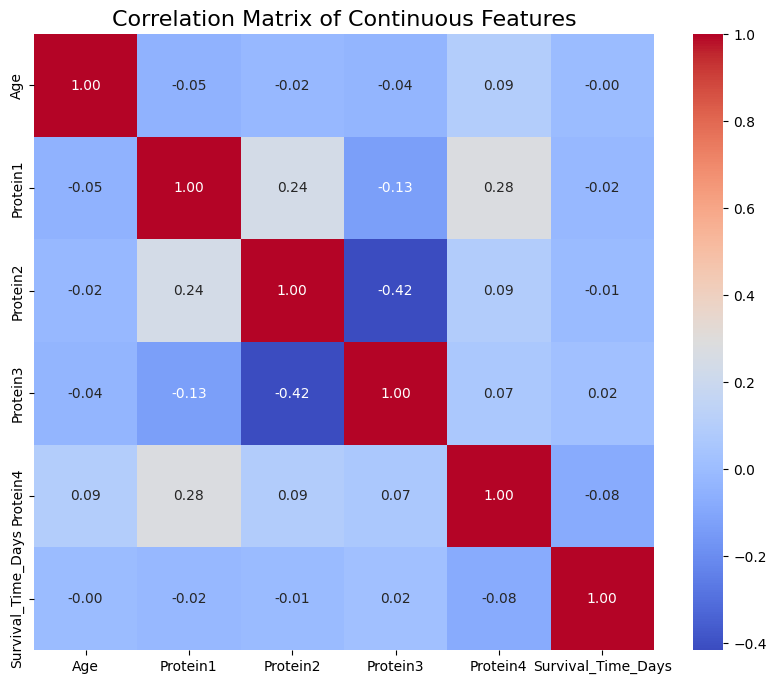

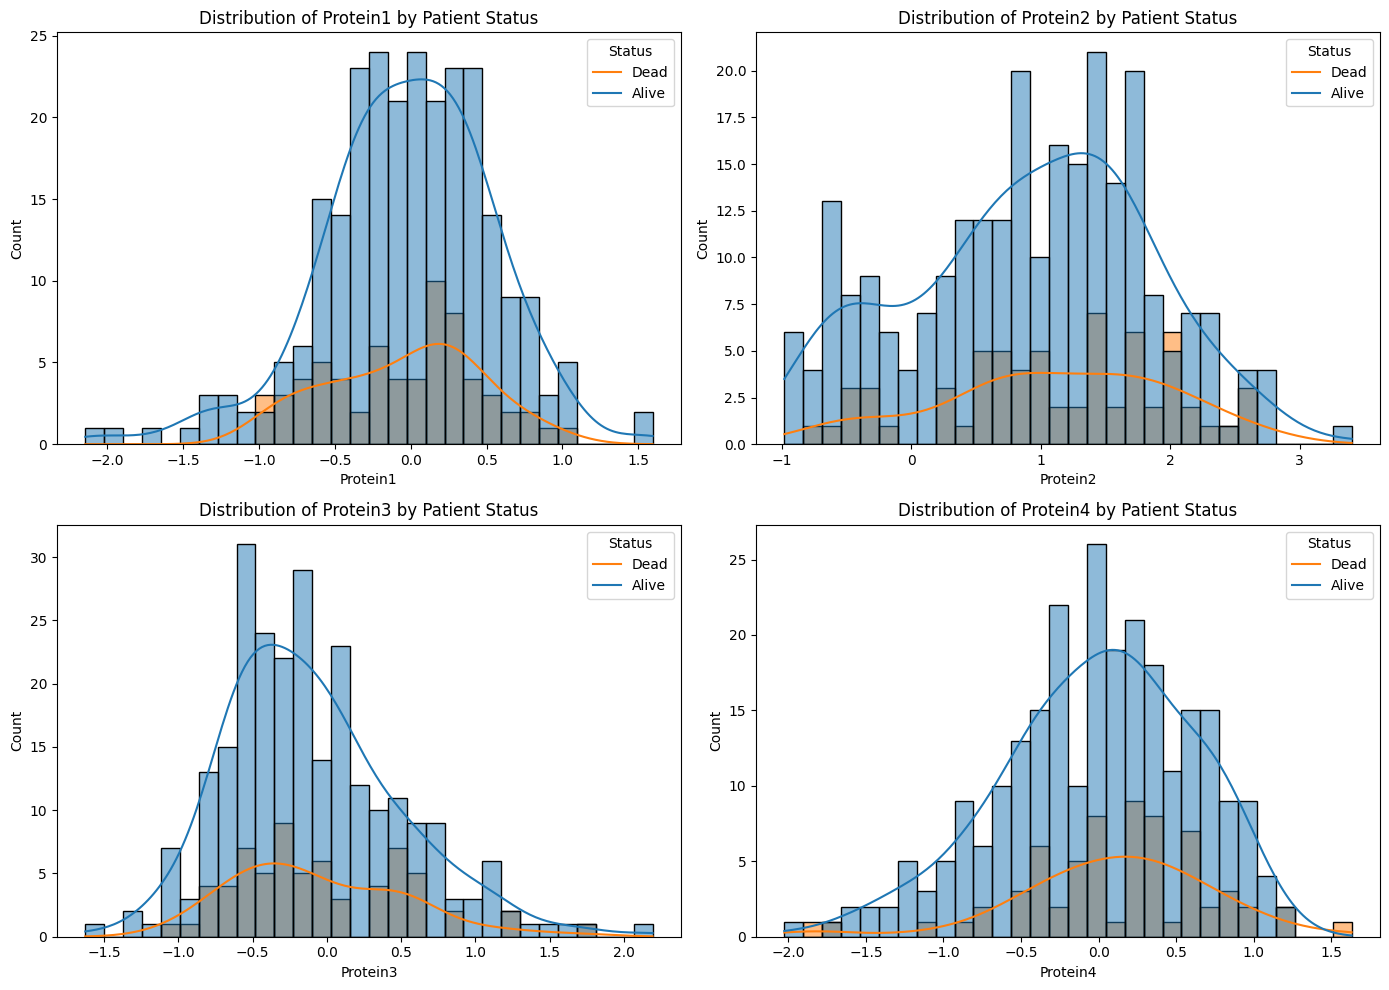

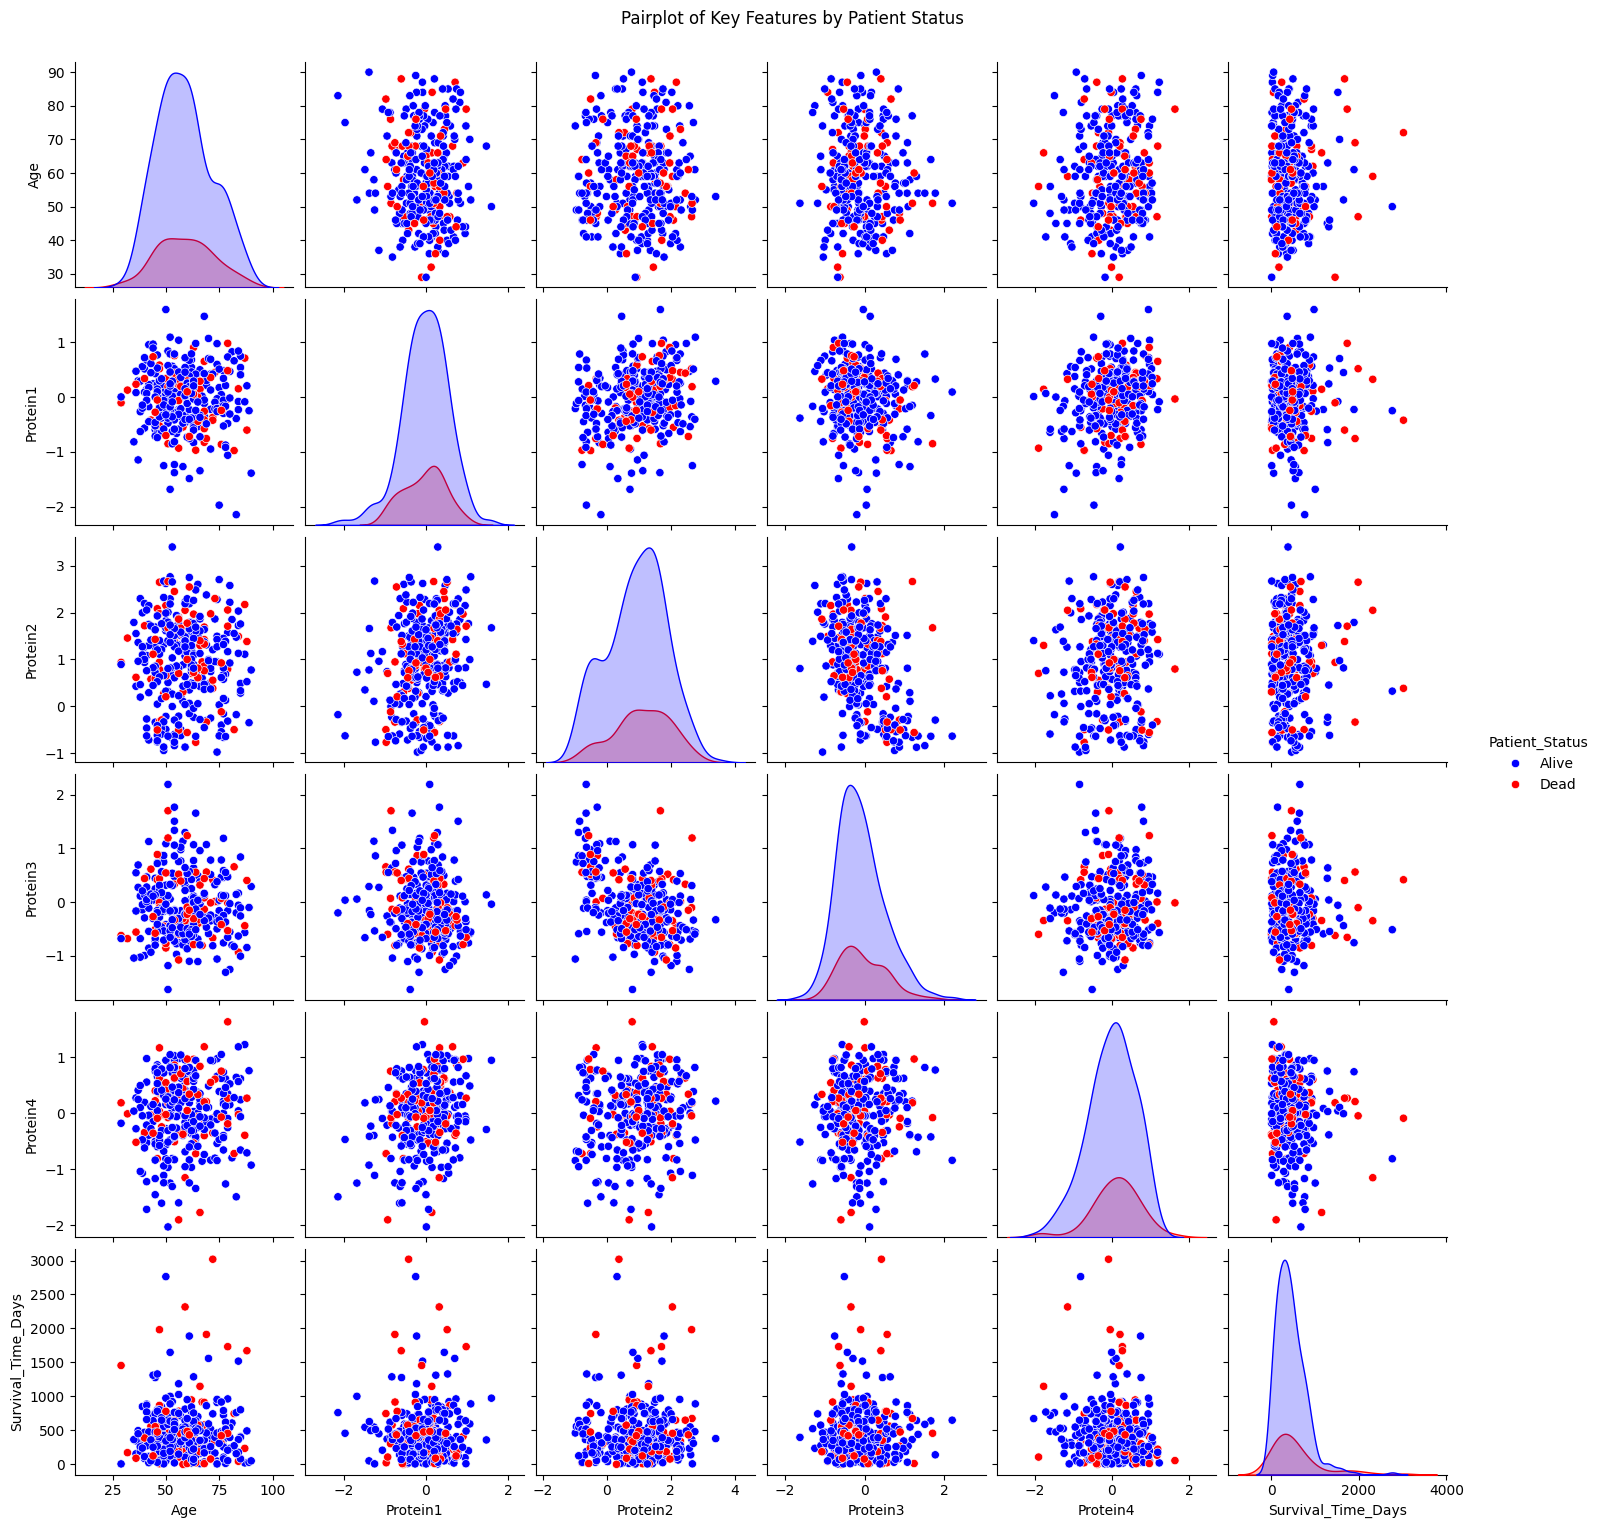

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load and Clean Data ---
df = pd.read_csv('BRCA.csv')
df.dropna(how='all', inplace=True) # Remove completely empty rows
df.columns = df.columns.str.strip() # Clean column names

# --- Feature Engineering: Survival Time ---
# Convert date columns to datetime objects
df['Date_of_Surgery'] = pd.to_datetime(df['Date_of_Surgery'], format='%d-%b-%y', errors='coerce')

# For 'Date_of_Last_Visit', we'll fill missing values for 'Alive' patients with a censor date (e.g., today)
# For 'Dead' patients, missing date of last visit is problematic, but we can assume it's close to date of death if that were known.
# For simplicity here, we'll use a recent date as a censor date for all missing values for this calculation.
# A more complex approach would involve imputation or external data.
censor_date = pd.to_datetime('2024-01-01')
df['Date_of_Last_Visit'] = pd.to_datetime(df['Date_of_Last_Visit'], format='%d-%b-%y', errors='coerce').fillna(censor_date)

# Calculate survival time in days
df['Survival_Time_Days'] = (df['Date_of_Last_Visit'] - df['Date_of_Surgery']).dt.days
# Remove nonsensical negative survival times if any
df = df[df['Survival_Time_Days'] >= 0]


# --- Data Visualization (EDA) ---
# 1. Correlation Heatmap of Protein Levels and Age
plt.figure(figsize=(10, 8))
corr_features = ['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Survival_Time_Days']
correlation_matrix = df[corr_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Continuous Features', fontsize=16)
plt.savefig("Correlation_Matrix.png", dpi=300)
plt.show()

# 2. Distribution of Protein Levels by Patient Status
plt.figure(figsize=(14, 10))
for i, col in enumerate(['Protein1', 'Protein2', 'Protein3', 'Protein4']):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col, hue='Patient_Status', kde=True, bins=30)
    plt.title(f'Distribution of {col} by Patient Status')
    plt.legend(title='Status', labels=['Dead', 'Alive'])
plt.tight_layout()
plt.savefig("Protein_Distribution_by_Status.png", dpi=300)
plt.show()

# 3. Pairplot to see relationships and distributions
sns.pairplot(df[corr_features + ['Patient_Status']], hue='Patient_Status', palette={ 'Alive':'blue', 'Dead':'red' })
plt.suptitle('Pairplot of Key Features by Patient Status', y=1.02)
plt.savefig("Pairplot_by_Status.png", dpi=300)
plt.show()

Original training set shape:  Patient_Status
0    191
1     49
Name: count, dtype: int64
Resampled training set shape:  Patient_Status
0    191
1    191
Name: count, dtype: int64


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:48:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Classification Report for Logistic Regression ---
              precision    recall  f1-score   support

       Alive       0.77      0.56      0.65        64
        Dead       0.18      0.35      0.24        17

    accuracy                           0.52        81
   macro avg       0.47      0.46      0.44        81
weighted avg       0.64      0.52      0.56        81

--- Classification Report for Random Forest ---
              precision    recall  f1-score   support

       Alive       0.79      0.75      0.77        64
        Dead       0.20      0.24      0.22        17

    accuracy                           0.64        81
   macro avg       0.49      0.49      0.49        81
weighted avg       0.66      0.64      0.65        81

--- Classification Report for XGBoost ---
              precision    recall  f1-score   support

       Alive       0.79      0.81      0.80        64
        Dead       0.20      0.18      0.19        17

    accuracy                          

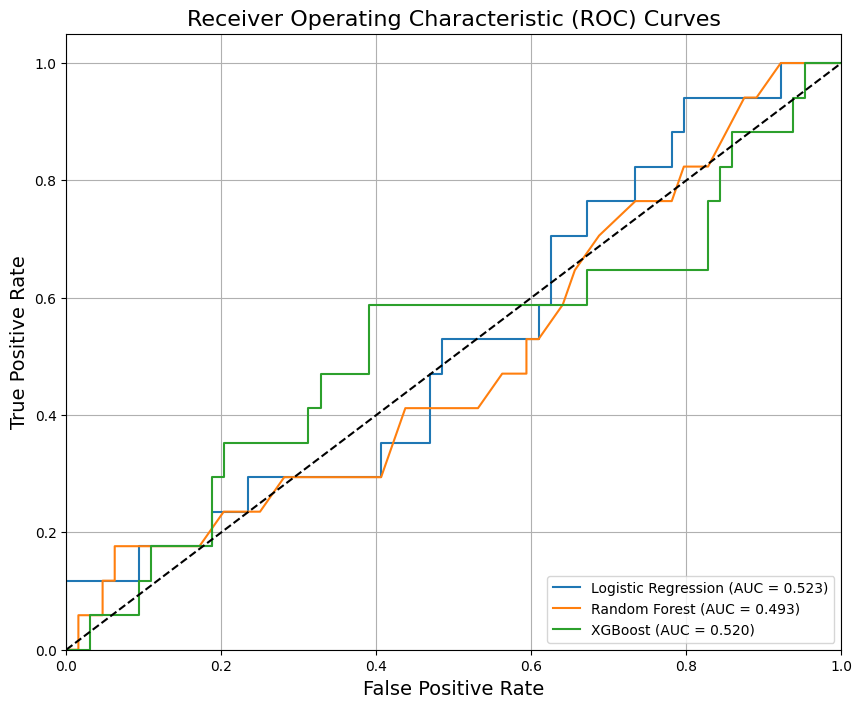

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# --- Preprocessing for Modeling ---
df_model = df.copy()
df_model.dropna(subset=['Patient_Status'], inplace=True)

# Encode all categorical features
cat_cols = ['Gender', 'Tumour_Stage', 'Histology', 'ER status', 'PR status', 'HER2 status', 'Surgery_type', 'Patient_Status']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    le_dict[col] = le

# Define features and target
features = ['Age', 'Protein1', 'Protein2', 'Protein3', 'Protein4', 'Tumour_Stage', 'Histology', 'HER2 status', 'Survival_Time_Days']
X = df_model[features]
y = df_model['Patient_Status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- Address Class Imbalance with SMOTE ---
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training set shape: ", y_train.value_counts())
print("Resampled training set shape: ", y_train_smote.value_counts())

# --- Model Training and Hyperparameter Tuning ---
# 1. Random Forest with GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)
best_rf = grid_rf.best_estimator_

# 2. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=sum(y_train==0)/sum(y_train==1))
xgb.fit(X_train, y_train) # XGBoost has built-in class weight handling

# 3. Logistic Regression
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr.fit(X_train_smote, y_train_smote)

# --- Evaluation and ROC Curve Plotting ---
models = {
    'Logistic Regression': lr,
    'Random Forest': best_rf,
    'XGBoost': xgb
}

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name == 'XGBoost':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    # Print classification reports
    y_pred = model.predict(X_test)
    print(f"--- Classification Report for {name} ---")
    print(classification_report(y_test, y_pred, target_names=['Alive', 'Dead']))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc="lower right")
plt.grid()
plt.savefig("ROC_Curves_Comparison.png", dpi=300)
plt.show()

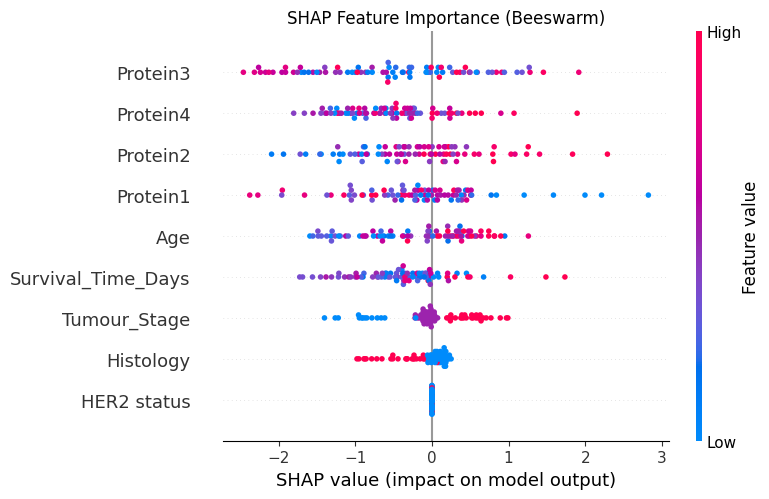

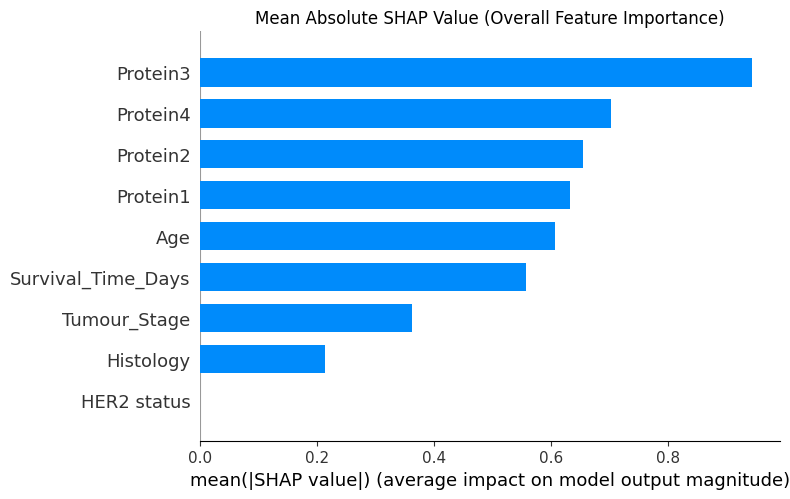

In [6]:
import shap

# --- SHAP Analysis on the best model (XGBoost) ---
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# 1. SHAP Summary Plot (Beeswarm)
plt.title("SHAP Feature Importance (Beeswarm)")
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.savefig("SHAP_Beeswarm_Plot.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. SHAP Feature Importance (Bar)
plt.title("Mean Absolute SHAP Value (Overall Feature Importance)")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("SHAP_Bar_Plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [5]:
!pip install lifelines

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=71d538222eed129a0d628b6cde6418693effa2bbb59f4bd80ff3703637103f09
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\50\37\21\0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


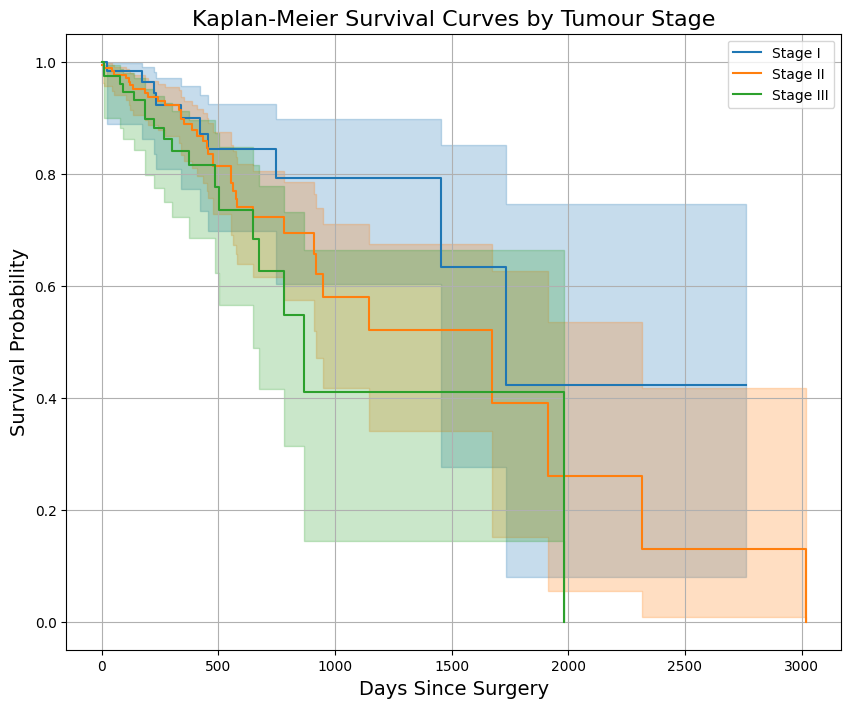


--- Cox Proportional-Hazards Model Summary ---


<lifelines.CoxPHFitter: fitted with 321 total observations, 255 right-censored observations>
             duration col = 'Survival_Time_Days'
                event col = 'event_observed'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 321
number of events observed = 66
   partial log-likelihood = -299.58
         time fit was run = 2025-06-14 18:48:30 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Age            -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
Protein1       -0.10      0.91      0.19           -0.46            0.27                0.63                1.31
Protein2        0.12      1.13      0.12           -0.10            0.35                0.90                1.42
Protein3        0.06      1.06      0.18           -0.30            0.42                0.74                1.52
Protein4        0.35      1.41      0.18            0.00            0.69                1.00                1.99
Tumour_Stage_1  0.13      1.14      0.23           -0.31            0.58                0.73                1.78
Tumour_Stage_2  0.40      1.50      0.27           -0.12            0.93                0.89                2.53
Histology_1    -0.13      0.88      0.24           -0.60            0.34                0.55                1.40
Histology_2     0.16      1.17      0.52           -0.86            1.17                0.42                3.22
HER2 status_1  -0.04      0.96      0.40           -0.82            0.74                0.44                2.09

                cmp to     z    p  -log2(p)
covariate                                  
Age               0.00 -0.07 0.94      0.08
Protein1          0.00 -0.53 0.60      0.74
Protein2          0.00  1.06 0.29      1.80
Protein3          0.00  0.31 0.76      0.40
Protein4          0.00  1.98 0.05      4.37
Tumour_Stage_1    0.00  0.59 0.55      0.85
Tumour_Stage_2    0.00  1.52 0.13      2.95
Histology_1       0.00 -0.55 0.58      0.78
Histology_2       0.00  0.30 0.76      0.39
HER2 status_1     0.00 -0.11 0.92      0.13
---
Concordance = 0.62
Partial AIC = 619.16
log-likelihood ratio test = 7.64 on 10 df
-log2(p) of ll-ratio test = 0.59

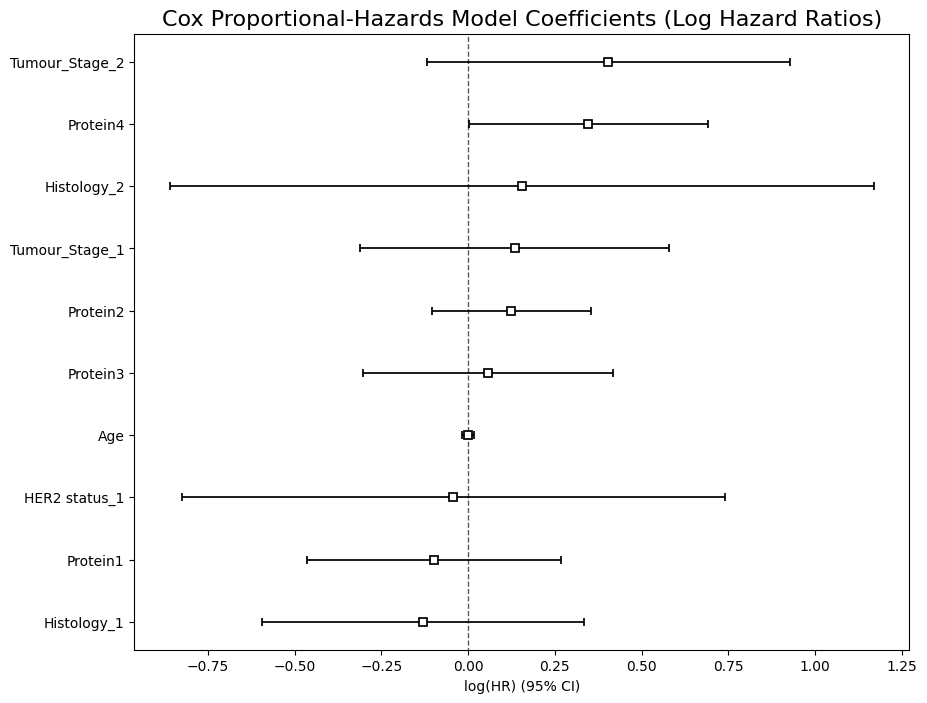

In [7]:
# !pip install lifelines # Run this once if you don't have it installed

from lifelines import KaplanMeierFitter, CoxPHFitter

# --- Prepare data for Survival Analysis ---
# 'event_observed' is 1 if the patient is Dead, 0 if Alive (censored)
df_survival = df_model.copy()
df_survival['event_observed'] = df_survival['Patient_Status'] # Dead=1, Alive=0

# --- Kaplan-Meier Survival Curves ---
plt.figure(figsize=(10, 8))
kmf = KaplanMeierFitter()

# Plot survival curves by Tumour Stage
ax = plt.subplot(111)
for stage, data in df_survival.groupby('Tumour_Stage'):
    stage_label = le_dict['Tumour_Stage'].inverse_transform([stage])[0]
    kmf.fit(data['Survival_Time_Days'], event_observed=data['event_observed'], label=f'Stage {stage_label}')
    kmf.plot_survival_function(ax=ax)

plt.title('Kaplan-Meier Survival Curves by Tumour Stage', fontsize=16)
plt.xlabel('Days Since Surgery', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.grid()
plt.savefig("Kaplan_Meier_Curves.png", dpi=300)
plt.show()

# --- Cox Proportional-Hazards Model ---
# We need to one-hot encode categorical features for the Cox model
df_cox = pd.get_dummies(df_survival[features + ['event_observed']], columns=['Tumour_Stage', 'Histology', 'HER2 status'], drop_first=True)

cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_cox, duration_col='Survival_Time_Days', event_col='event_observed')

print("\n--- Cox Proportional-Hazards Model Summary ---")
cph.print_summary()

# Plot the coefficients (hazard ratios)
plt.figure(figsize=(10, 8))
cph.plot()
plt.title('Cox Proportional-Hazards Model Coefficients (Log Hazard Ratios)', fontsize=16)
plt.savefig("Cox_Model_Coefficients.png", dpi=300)
plt.show()